<a href="https://colab.research.google.com/github/halfChewedGum/ECON626Competitions/blob/main/competition5_OyWithThePoodles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **RESULTS**

## **Competition 5**

### Name : OyWithThePoodles

-----------------------------

|MODEL|Parameters|MSE|R-Squared|
|-----|----------|---|---------|
|Linear Regression|14 predictors|61,982.86|73%|
|Decision tree|Depth-max: 15|74,268.69|66%|
|**Random Forest**|-|**38,577.02**|**78%**|
|Deep Neural Network on 5 features|ReLu, 50 neurons, 2 layers|6,144,326|17%|
|Deep Neural Network on 5 features|ReLu, 100 neurons, 2 layers|1,031,400.10|-|
|**Deep Neural Network on 14 features**|**ReLu, 57 neurons, 8 layers**|**70,066.52**|**61%**|
|Deep Neural Network on 14 features|ReLu, 98 neurons, 5 layers|73,358.57|50%|
|Deep Neural Network on 14 features|ReLu, 65 neurons, 6 layers|-|27%|


So, the overall best is Random Forest but the best Deep Learning algorithm is a Deep Neural Network with ReLu activation, 57 neurons and 8 layers. It gives us a 61% accuracy (R2). 


In [75]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

from google.colab import files
uploaded = files.upload()

Saving training.csv to training (1).csv


In [76]:
import io
df = pd.read_csv(io.BytesIO(uploaded['training.csv']))


In [83]:
cols = list(df.columns)
cols

['team_abbreviation',
 'age',
 'player_height',
 'player_weight',
 'college',
 'country',
 'draft_year',
 'draft_round',
 'draft_number',
 'gp',
 'pts',
 'reb',
 'ast',
 'net_rating',
 'oreb_pct',
 'dreb_pct',
 'usg_pct',
 'ts_pct',
 'ast_pct',
 'season']

TO DO

1. randomly select some players and put them in a separate dataframe
2. See what you can drive from each players data: throughout seasons what has happened to them (team change, height/weight change, age change, points, etc) 

Why: 

this will give you an idea of what is more important here. Ultimately, I want to predict how many points a certain player will score based on his age, height, weight, team, country, and any other relavant data in an upcoming season. 

Let's look at it like this: 

- Player A's dataset tracks the progress of player A throughout his career. 

OR 

- Let's forget that players are repeated, so set aside players and just think "a person" without taking into account his background. This way, the data won't be time-series. 

In [78]:
df = df.drop(columns = ['v1', 'player_name'])
df.head()

,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,draft_number,gp,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season
0,LAL,22,213.36,106.5941,Connecticut,USA,1996,1,29,71,4.8,4.5,0.5,6.2,0.127,0.182,0.142,0.536,0.052,1996-97
1,MIA,27,210.82,106.5941,North Carolina-Wilmington,USA,1992,2,50,6,0.3,0.8,0.0,-15.1,0.143,0.267,0.265,0.333,0.000,1996-97
2,HOU,30,208.28,106.5941,Iowa,USA,Undrafted,Undrafted,Undrafted,71,4.5,1.6,0.9,0.9,0.016,0.115,0.151,0.535,0.099,1996-97
3,BOS,29,210.82,111.1300,Providence,USA,Undrafted,Undrafted,Undrafted,74,7.8,4.4,1.4,-9.0,0.083,0.152,0.167,0.542,0.101,1996-97
4,DAL,22,205.74,106.5941,None,USA,1996,1,25,42,3.7,1.6,0.5,-14.5,0.109,0.118,0.233,0.482,0.114,1996-97


In [79]:
#convert all categorical data into numerical data
df['draft_year'] = df['draft_year'].replace('Undrafted', '2002')

#then, change everything to integer 
df['draft_year'] = pd.to_numeric(df['draft_year'])

print('min: ', df['draft_year'].min())
print('max: ', df['draft_year'].max())

min:  1963
max:  2019


In [80]:
df_copy = df
df_new = df.drop(df[df.season == '2020-21'].index, inplace=True)


In [81]:
'2020-21' in df['season']

False

In [84]:
#which columns are objects ? 

object_type_cols = []
for col in cols: 
  if df[col].dtype == 'object':
    object_type_cols.append(col)

object_type_cols

['team_abbreviation',
 'college',
 'country',
 'draft_round',
 'draft_number',
 'season']

In [85]:
#how many unique values are there in each: 

for el in object_type_cols:
  print(el, ' has ', df[el].nunique(), ' values.')

team_abbreviation  has  36  values.
college  has  329  values.
country  has  78  values.
draft_round  has  9  values.
draft_number  has  76  values.
season  has  24  values.


In [86]:
def factorize_els(el_list):
  codes, uniques = pd.factorize(el_list)

  return codes, uniques

teams = [x for x in df['team_abbreviation']]
colleges = [x for x in df['college']]
country = [x for x in df['country']]
draft_round = [x for x in df['draft_round']]
draft_number = [x for x in df['draft_number']]
season = [x for x in df['season']]

team_codes = factorize_els(teams)[0]
college_codes = factorize_els(colleges)[0]
country_codes = factorize_els(country)[0]
draft_round_codes = factorize_els(draft_round)[0]
draft_number_codes = factorize_els(draft_number)[0]
season_codes = factorize_els(season)[0]

#example: 
print(team_codes[:10])
print(team_codes.shape)

[0 1 2 3 4 5 6 1 7 8]
(11160,)


In [87]:
#put these back into dataframe 

age = np.array(df['age']).reshape(-1,1)
height = np.array(df['player_height']).reshape(-1,1)
weight = np.array(df['player_weight']).reshape(-1,1)
draft_year = np.array(df['draft_year']).reshape(-1,1)
score = (np.array(df['gp']) * np.array(df['pts'])).reshape(-1,1)
rebound = np.array(df['reb']).reshape(-1,1)
ast = np.array(df['ast']).reshape(-1,1)
net_rating = np.array(df['net_rating']).reshape(-1,1)
oreb_pct = np.array(df['oreb_pct']).reshape(-1,1)
dreb_pct = np.array(df['dreb_pct']).reshape(-1,1)
usg_pct = np.array(df['usg_pct']).reshape(-1,1)
ts_pct = np.array(df['ts_pct']).reshape(-1,1)
ast_pct = np.array(df['ast_pct']).reshape(-1,1)


conct = np.concatenate((team_codes.reshape(-1,1), college_codes.reshape(-1,1), 
                        country_codes.reshape(-1,1), draft_round_codes.reshape(-1,1), 
                        draft_number_codes.reshape(-1,1), season_codes.reshape(-1,1),
                        age, height, weight, draft_year, score, rebound, ast, net_rating,
                        oreb_pct, dreb_pct, usg_pct, ts_pct, ast_pct), axis = 1)

print(conct.shape)



(11160, 19)


In [88]:
dataset = pd.DataFrame(conct, columns = ['team', 'uni', 'country', 'd_round', 'd_num', 'season', 'age', 'height', 'weight',
                                         'd_year', 'score', 'rebound', 'ast', 'net_rating', 'oreb', 'dreb', 'usg', 'ts', 'ast_pct'])

dataset.head()

,team,uni,country,d_round,d_num,season,age,height,weight,d_year,score,rebound,ast,net_rating,oreb,dreb,usg,ts,ast_pct
0,0.0,0.0,0.0,0.0,0.0,0.0,22.0,213.36,106.5941,1996.0,340.8,4.5,0.5,6.2,0.127,0.182,0.142,0.536,0.052
1,1.0,1.0,0.0,1.0,1.0,0.0,27.0,210.82,106.5941,1992.0,1.8,0.8,0.0,-15.1,0.143,0.267,0.265,0.333,0.000
2,2.0,2.0,0.0,2.0,2.0,0.0,30.0,208.28,106.5941,2002.0,319.5,1.6,0.9,0.9,0.016,0.115,0.151,0.535,0.099
3,3.0,3.0,0.0,2.0,2.0,0.0,29.0,210.82,111.1300,2002.0,577.2,4.4,1.4,-9.0,0.083,0.152,0.167,0.542,0.101
4,4.0,4.0,0.0,0.0,3.0,0.0,22.0,205.74,106.5941,1996.0,155.4,1.6,0.5,-14.5,0.109,0.118,0.233,0.482,0.114


In [89]:
#all imports 
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


In [90]:
features = ['team', 'uni', 'country', 'd_round', 'd_num', 'season', 'age', 'height', 'weight',
            'd_year', 'rebound', 'ast', 'net_rating', 'oreb', 'dreb', 'usg', 'ts', 'ast']

target = dataset['score']

dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11160 entries, 0 to 11159
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   team        11160 non-null  float64
 1   uni         11160 non-null  float64
 2   country     11160 non-null  float64
 3   d_round     11160 non-null  float64
 4   d_num       11160 non-null  float64
 5   season      11160 non-null  float64
 6   age         11160 non-null  float64
 7   height      11160 non-null  float64
 8   weight      11160 non-null  float64
 9   d_year      11160 non-null  float64
 10  score       11160 non-null  float64
 11  rebound     11160 non-null  float64
 12  ast         11160 non-null  float64
 13  net_rating  11160 non-null  float64
 14  oreb        11160 non-null  float64
 15  dreb        11160 non-null  float64
 16  usg         11160 non-null  float64
 17  ts          11160 non-null  float64
 18  ast_pct     11160 non-null  float64
dtypes: float64(19)
memory usa

In [91]:
first_half = dataset[['team', 'uni', 'country', 'd_round', 'd_num', 'season', 'age', 'height', 'weight', 'score']]
second_half = dataset[['score', 'd_year', 'rebound','ast','net_rating', 'oreb', 'dreb', 'usg', 'ts', 'ast_pct']]

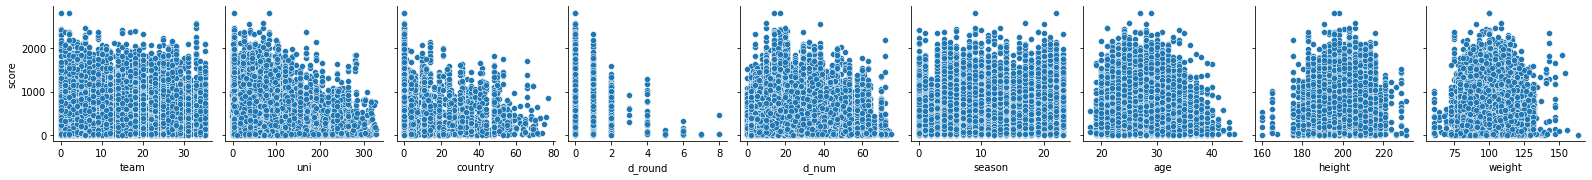

In [92]:
sns.pairplot(first_half, x_vars = ['team', 'uni', 'country', 'd_round', 'd_num', 'season', 'age', 'height', 'weight'], y_vars = ['score'])

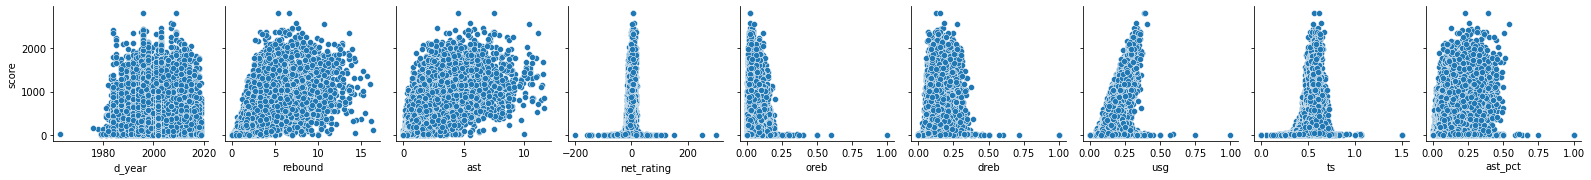

In [93]:
sns.pairplot(second_half, x_vars = ['d_year', 'rebound','ast', 'net_rating', 'oreb', 'dreb', 'usg', 'ts', 'ast_pct'], y_vars = ['score'])

Looking at the two set of figures above: 

* score-team : no relationship
* score-uni : some unis have done better 
* score-country : some countries done better 
* d-round : earlier draft rounds better (negative rel)
* d-num : weird relationship ? 
* season : almost no relationship 
* age : normal ? 
* height : normal ? 
* weight : normal ? 
---------------------------------------------
* draft-year : no relationship 
* rebound : positive relationship 
* ast : positive relationship 
* net_rating : normal ---> very weird ! 
* order : skewed to the right, exponential, negative relationship 
* dreb : same ^
* usg : positive linear 
* ts : normal 
* ast_pct : almost positive linear 

In [94]:
#dropping a few of these features: 

x_model1 = dataset[['uni', 'country', 'd_round', 'd_num', 'season', 'age', 'height', 'weight',
                    'd_year', 'rebound', 'ast', 'net_rating', 'oreb', 'dreb', 'usg', 'ts', 'ast']] #team deleted
x_model2 = dataset[['team', 'uni', 'country', 'd_round', 'd_num', 'age', 'height', 'weight',
                    'd_year', 'rebound', 'ast', 'net_rating', 'oreb', 'dreb', 'usg', 'ts', 'ast']] #season deleted
x_model3 = dataset[['team', 'uni', 'country', 'd_round', 'd_num', 'season', 'age', 'height', 'weight',
                    'd_year', 'rebound', 'ast','oreb', 'dreb', 'usg', 'ts', 'ast']] #net_rating deleted
x_model4 = dataset[['team', 'uni', 'country', 'd_round', 'd_num', 'season', 'age', 'height', 'weight',
                    'd_year', 'rebound', 'ast', 'net_rating', 'oreb', 'dreb', 'usg', 'ast']] #ts deleted 
x_model5 = dataset[['uni', 'country', 'd_round', 'd_num', 'age', 'height', 'weight',
                    'd_year', 'rebound', 'ast', 'oreb', 'dreb', 'usg', 'ast']] #all above deleted 

# for later : can try different combinations too 

In [95]:
#normalizer 
from sklearn import preprocessing

def norm_predictors(x):
  """ Takes in a dataframe X and returns a normalized version using MinMaxScaling"""
  cols = list(x.columns)
  x = np.array(x) #first convert to array
  minMax = preprocessing.MinMaxScaler()
  x_scale = minMax.fit_transform(x)
  df = pd.DataFrame(x_scale, columns = cols)

  return df 

norm_data = norm_predictors(dataset)
norm_data.head()

,team,uni,country,d_round,d_num,season,age,height,weight,d_year,score,rebound,ast,net_rating,oreb,dreb,usg,ts,ast_pct
0,0.000000,0.003040,0.0,0.000,0.000000,0.0,0.153846,0.750000,0.449339,0.589286,0.120339,0.276074,0.042735,0.4124,0.127,0.182,0.142,0.357333,0.052
1,0.028571,0.006079,0.0,0.125,0.013333,0.0,0.346154,0.714286,0.449339,0.517857,0.000636,0.049080,0.000000,0.3698,0.143,0.267,0.265,0.222000,0.000
2,0.057143,0.009119,0.0,0.250,0.026667,0.0,0.461538,0.678571,0.449339,0.696429,0.112818,0.098160,0.076923,0.4018,0.016,0.115,0.151,0.356667,0.099
3,0.085714,0.012158,0.0,0.250,0.026667,0.0,0.423077,0.714286,0.493392,0.696429,0.203814,0.269939,0.119658,0.3820,0.083,0.152,0.167,0.361333,0.101
4,0.114286,0.015198,0.0,0.000,0.040000,0.0,0.153846,0.642857,0.449339,0.589286,0.054873,0.098160,0.042735,0.3710,0.109,0.118,0.233,0.321333,0.114


### NEURAL NETWORKS 

In [97]:
#find best model 

def findbestmodel(n_hidden = 2, n_neurons = 30, learning_rate = 0.01, input_shape = [17]):
  model = keras.models.Sequential() 
  model.add(keras.layers.InputLayer(input_shape = input_shape, name = 'input_layer'))

  #hidden layers 
  for i in range(n_hidden):
    model.add(keras.layers.Dense(n_neurons, activation = 'relu', name = 'hidden_%s' % i))

  model.add(keras.layers.Dense(1, name = 'output_layer'))

  optimizer = keras.optimizers.Adam(learning_rate = learning_rate)
  
  model.compile(loss = 'mse', optimizer = optimizer)

  return model 

def findbestmodel14(n_hidden = 2, n_neurons = 30, learning_rate = 0.01, input_shape = [14]):
  model = keras.models.Sequential() 
  model.add(keras.layers.InputLayer(input_shape = input_shape, name = 'input_layer'))

  #hidden layers 
  for i in range(n_hidden):
    model.add(keras.layers.Dense(n_neurons, activation = 'relu', name = 'hidden_%s' % i))

  model.add(keras.layers.Dense(1, name = 'output_layer'))

  optimizer = keras.optimizers.Adam(learning_rate = learning_rate)
  
  model.compile(loss = 'mse', optimizer = optimizer)

  return model 


In [98]:
#predictors and target train and validation sets 

x1_train, x1_val, y1_train, y1_val = train_test_split(x_model1, target, test_size = 0.2, random_state = 0)
x2_train, x2_val, y2_train, y2_val = train_test_split(x_model2, target, test_size = 0.2, random_state = 0)
x3_train, x3_val, y3_train, y3_val = train_test_split(x_model3, target, test_size = 0.2, random_state = 0)
x4_train, x4_val, y4_train, y4_val = train_test_split(x_model4, target, test_size = 0.2, random_state = 0)
x5_train, x5_val, y5_train, y5_val = train_test_split(x_model5, target, test_size = 0.2, random_state = 0)



In [99]:
#Define the hyperparameter space
params = {
          'model__n_hidden': np.arange(1,21),
          'model__n_neurons': np.arange(19,101), 
          'optimizer__learning_rate': [0.01, 0.001, 0.0001]
}

#model I want to use 
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV

kerasReg1 = KerasRegressor(findbestmodel, verbose = 0)
kerasReg2 = KerasRegressor(findbestmodel14, verbose = 0)

def find_best_params(p, m, x, y, cv):
  rnd_search = RandomizedSearchCV(m, param_distributions= p, n_iter = 10, cv = cv) 
  rnd_search_result = rnd_search.fit(x, y)
  
  best_par = rnd_search_result.best_params_
  best_score = rnd_search_result.best_score_
  best_estimate = rnd_search_result.best_estimator_

  return best_par, best_score, best_estimate




In [100]:
#testing for different models: 

dict_model_comparison = {
    'model_1': [],
    'model_2': [],
    'model_3': [],
    'model_4': [],
    'model_5': []
}

column_names = ['Best Parameters', 'Best Score', 'Best Estimates']

#fill the dictionary
dict_model_comparison['model_1'] = find_best_params(params, kerasReg1, x1_train, y1_train, 10)
dict_model_comparison['model_2'] = find_best_params(params, kerasReg1, x2_train, y2_train, 10)
dict_model_comparison['model_3'] = find_best_params(params, kerasReg1, x3_train, y3_train, 10)
dict_model_comparison['model_4'] = find_best_params(params, kerasReg1, x4_train, y4_train, 10)
dict_model_comparison['model_5'] = find_best_params(params, kerasReg2, x5_train, y5_train, 10)



In [101]:
df_model_comparisons = pd.DataFrame.from_dict(dict_model_comparison, orient = 'index', columns = column_names)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000000)
df_model_comparisons

,Best Parameters,Best Score,Best Estimates
model_1,"{'optimizer__learning_rate': 0.01, 'model__n_n...",0.360433,KerasRegressor(\n\tmodel=<function findbestmod...
model_2,"{'optimizer__learning_rate': 0.0001, 'model__n...",0.323507,KerasRegressor(\n\tmodel=<function findbestmod...
model_3,"{'optimizer__learning_rate': 0.01, 'model__n_n...",0.440285,KerasRegressor(\n\tmodel=<function findbestmod...
model_4,"{'optimizer__learning_rate': 0.001, 'model__n_...",0.409954,KerasRegressor(\n\tmodel=<function findbestmod...
model_5,"{'optimizer__learning_rate': 0.001, 'model__n_...",0.457028,KerasRegressor(\n\tmodel=<function findbestmod...


model 1 : team excluded 

model 2 : season excluded

model 3 : net_ratings excluded

model 4 : ts excluded 

model 5 : all of the above excluded 

In [114]:
# best model is chosen : model 5 
def build_deploy_model(n_neuron, n_layers, input_shape, l_rate, x, y, xval, yval, activ):
  model = keras.models.Sequential()

  model.add(keras.layers.InputLayer(input_shape = input_shape, name = 'input_layer'))

  for i in range(n_layers):
    model.add(keras.layers.Dense(n_neuron, activation = activ, name = 'hidden_%s' % i))

  model.add(keras.layers.Dense(1, name = 'output_layer'))

  optimizer = keras.optimizers.Adam(learning_rate = l_rate)

  model.compile(loss = 'mse', optimizer = optimizer)

  print('model exec time: ')
  %time
  history = model.fit(
      x,
      y,
      epochs=100,
      verbose=0,
      validation_split = 0.2)
  
  evals = model.evaluate(xval, yval)
  y_pred = model.predict(xval)
  mse = mean_squared_error(y_pred, yval)
  r2 = r2_score(y_pred, yval)

  model_info = {
      'model' : model,
      'evaluation' : evals,
      'prediction' : y_pred,
      'MSE' : mse,
      'R-Squared' : r2, 
      'history' : history
  }

  return model_info 

information_dict = build_deploy_model(98, 5, [14], 0.001, x5_train, y5_train, x5_val, y5_val, 'relu')





model exec time: 
CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.78 µs
70/70 [==============================] - 0s 2ms/step - loss: 70066.5234


In [115]:
print('Model Summary : ')
print('-----------------------------------------------------------')

information_dict['model'].summary()







Model Summary : 
-----------------------------------------------------------
Model: "sequential_1823"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_0 (Dense)            (None, 98)                1470      
                                                                 
 hidden_1 (Dense)            (None, 98)                9702      
                                                                 
 hidden_2 (Dense)            (None, 98)                9702      
                                                                 
 hidden_3 (Dense)            (None, 98)                9702      
                                                                 
 hidden_4 (Dense)            (None, 98)                9702      
                                                                 
 output_layer (Dense)        (None, 1)                 99        
                                        

In [116]:
print('Model run History (end) : ')
print('-----------------------------------------------------------')

hist = pd.DataFrame(information_dict['history'].history)
hist['epoch'] = information_dict['history'].epoch
hist.tail()

Model run History (end) : 
-----------------------------------------------------------


,loss,val_loss,epoch
95,66862.953125,65301.000000,95
96,67616.515625,72278.632812,96
97,66104.726562,68428.656250,97
98,65012.925781,63927.539062,98
99,68447.851562,69163.585938,99


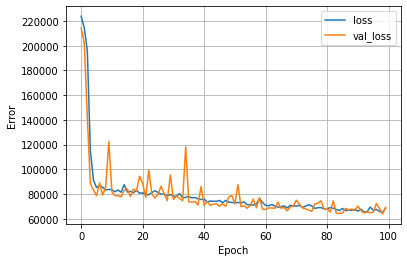

In [117]:
def plot_loss(history):
  plt.plot(information_dict['history'].history['loss'], label='loss')
  plt.plot(information_dict['history'].history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

plot_loss(information_dict['history'])

In [118]:
print('result of the model: ')
information_dict

result of the model: 


{'MSE': 70066.51993766987,
 'R-Squared': 0.6139602326350224,
 'evaluation': 70066.5234375,
 'history': <keras.callbacks.History at 0x7f12d6ff9390>,
 'model': <keras.engine.sequential.Sequential at 0x7f12fe8cedd0>,
 'prediction': array([[ 413.41528 ],
        [  56.601295],
        [ 539.19025 ],
        ...,
        [1009.8676  ],
        [ 367.11618 ],
        [ 449.49854 ]], dtype=float32)}

### Comparison with Random Forest and Decision Tree





In [119]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor(max_depth = 15)
dt.fit(x5_train, y5_train)
dt_preds = dt.predict(x5_val)

dt_mse = mean_squared_error(dt_preds, y5_val)
dt_r2 = r2_score(dt_preds, y5_val)

print('Decision Tree MSE: ', dt_mse)
print('Decision Tree R2: ', dt_r2)

Decision Tree MSE:  72553.8028116642
Decision Tree R2:  0.6615427769950403


In [120]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(max_depth = 15, random_state = 0)
rfr.fit(x5_train, y5_train)
rfr_pred = rfr.predict(x5_val)

rfr_mse = mean_squared_error(rfr_pred, y5_val)
rfr_r2 = r2_score(rfr_pred, y5_val)

print('Random Forest MSE: ', rfr_mse)
print('Random Forest R2: ', rfr_r2)

Random Forest MSE:  38577.02353109294
Random Forest R2:  0.7849278776610464


In [121]:
#feature importance based on RF

list_cols = ['uni', 'country', 'd_round', 'd_num', 'age', 'height', 'weight',
             'd_year', 'rebound', 'ast', 'oreb', 'dreb', 'usg', 'ast']

importances = list(rfr.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(list_cols, importances)]

feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

for i in range(len(feature_importances)):
  print(feature_importances[i])

('usg', 0.25)
('rebound', 0.23)
('ast', 0.21)
('ast', 0.15)
('dreb', 0.05)
('oreb', 0.03)
('uni', 0.01)
('d_num', 0.01)
('age', 0.01)
('height', 0.01)
('weight', 0.01)
('d_year', 0.01)
('country', 0.0)
('d_round', 0.0)


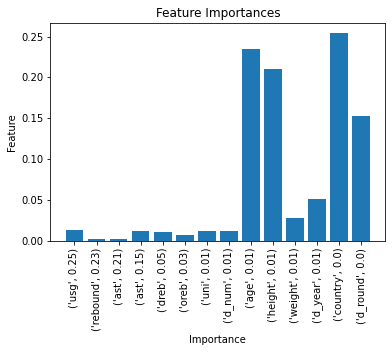

In [122]:
#visualize this 
plt.bar(list(range(len(importances))), importances)
plt.xticks(list(range(len(importances))), feature_importances, rotation = 'vertical')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

In [123]:
#linear regression 
import statsmodels.api as sm

x5 = sm.add_constant(x5_train, prepend = False)
lin_reg = sm.OLS(y5_train, x5)
res = lin_reg.fit()
print(res.summary())



                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.729
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     1841.
Date:                Wed, 16 Mar 2022   Prob (F-statistic):               0.00
Time:                        17:46:32   Log-Likelihood:                -61736.
No. Observations:                8928   AIC:                         1.235e+05
Df Residuals:                    8914   BIC:                         1.236e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
uni           -0.1198      0.040     -2.963      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [124]:
x5_val_ = sm.add_constant(x5_val, prepend = False)
lin_reg_pred = res.predict(x5_val_)
lin_reg_mse = mean_squared_error(lin_reg_pred, y5_val)

print('Linear Regression MSE: ', lin_reg_mse)

Linear Regression MSE:  61982.861165470465


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [125]:
#using another activation function 
import tensorflow as tf

def findSingleBest(act = 'relu', n_layer = 2, n_neuron = 30, l_rate = 0.01, inp_shape = [14]):
  """Tests out different activation functions and finds the best one"""
  model = keras.models.Sequential() 
  model.add(keras.layers.InputLayer(input_shape = inp_shape, name = 'input_layer'))

  #hidden layers 
  for i in range(n_layer):
    model.add(keras.layers.Dense(n_neuron, activation = act, name = 'hidden_%s' % i))

  model.add(keras.layers.Dense(1, name = 'output_layer'))

  optimizer = keras.optimizers.Adam(learning_rate = l_rate)
  
  model.compile(loss = 'mse', optimizer = optimizer)

  return model 


kerasReg_ = KerasRegressor(findSingleBest, verbose = 0)

def find_best_params(p, m, x, y, cv):
  rnd_search = RandomizedSearchCV(m, param_distributions= p, n_iter = 10, cv = cv) 
  rnd_search_result = rnd_search.fit(x, y)
  
  best_par = rnd_search_result.best_params_
  best_score = rnd_search_result.best_score_
  best_estimate = rnd_search_result.best_estimator_

  return best_par, best_score, best_estimate

params_to_test = {
    'model__act': ['relu', 'tanh', 'selu'],
    'model__n_layer' : np.arange(2,81),
    'model__n_neuron' : np.arange(15, 101),
    'optimizer__l_rate' : [0.01, 0.001, 0.0001, 0.00001]
}  


# def build_deploy_model(n_neuron, n_layers, input_shape, l_rate, x, y, xval, yval, activ):

dict_model_comparison_ = {
    'model_relu': [],
    'model_tanh': [],
    'model_selu': [],
}

#fill the dictionary
dict_model_comparison_['model_relu'] = find_best_params(params_to_test, kerasReg_, x5_train, y5_train, 10)
dict_model_comparison_['model_tanh'] = find_best_params(params_to_test, kerasReg_, x5_train, y5_train, 10)
dict_model_comparison_['model_selu'] = find_best_params(params_to_test, kerasReg_, x5_train, y5_train, 10)


df_model_comparisons_ = pd.DataFrame.from_dict(dict_model_comparison_, orient = 'index', columns = column_names)

df_model_comparisons_



,Best Parameters,Best Score,Best Estimates
model_relu,"{'optimizer__l_rate': 0.001, 'model__n_neuron'...",0.032103,KerasRegressor(\n\tmodel=<function findSingleB...
model_tanh,"{'optimizer__l_rate': 0.0001, 'model__n_neuron...",-0.016893,KerasRegressor(\n\tmodel=<function findSingleB...
model_selu,"{'optimizer__l_rate': 1e-05, 'model__n_neuron'...",0.277117,KerasRegressor(\n\tmodel=<function findSingleB...


So, still the best one is the ReLu model with 98 neurons and 5 Layers. 

In [ ]:
# import visualkeras
# visualkeras.layered_view(model)


from ann_visualizer.visualize import ann_viz

ann_viz(information_dict['model'], title="Neural Network")